## Librerias

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import seed
seed(1) ### Para no variar los aleatorios
%matplotlib inline
%reload_ext rpy2.ipython

## Aclaraciones
Para el preprocesamiento de los datos, se utiliza una metodologia propuesta por el profesor Juan David Velásquez Henao aplicada en el siguiente ejemplo: https://jdvelasq.github.io/courses/notebooks/sklearn/bayes/02-filtrado-de-mensajes-sms.html

## Lectura de datos

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ANN-2019-2/evaluacion-cdbolivarz/master/datos/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Cantidad de mensajes por tipo

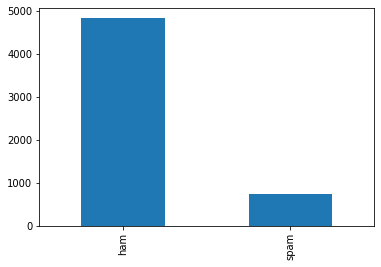

In [3]:
df.type.value_counts().plot.bar();

En la base de datos se perciben mas mensajes que no son spam

## Preprocesamiento

### Stemmer
Para este primer paso, se lleva todo a minusculas y se quita la conjugacion

In [4]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


### Normalización

In [0]:

##
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

vocabulary = count_vect.get_feature_names()

##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

## Conjuntos de entrenamiento y prueba

In [0]:
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      = dtm[0:4168,]
X_test       = dtm[4169:,]
y_train_true = df.type[0:4168]
y_test_true  = df.type[4169:]

In [7]:
##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_train_true.value_counts() / sum(y_train_true.value_counts()), 1)

ham     86.5
spam    13.5
Name: type, dtype: float64

In [8]:

##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_test_true.value_counts() / sum(y_test_true.value_counts()), 1)

ham     87.0
spam    13.0
Name: type, dtype: float64

## Clasificación

### Modelo base
Para el modelo base se utiliza un modelo de regresión logística, ya que al arrojar como resultado 1 ó 0 puede separar los datos por clases.

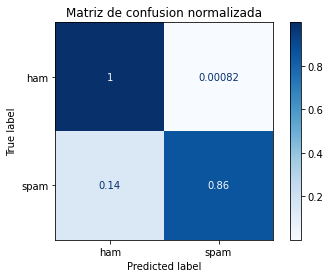

In [9]:

base_model = LogisticRegression(random_state=420).fit(X_train, y_train_true)
cm = plot_confusion_matrix(base_model, X_test, y_test_true,
                           display_labels=['ham', 'spam'],
                           cmap=plt.cm.Blues,
                           normalize='true')
cm.ax_.set_title("Matriz de confusion normalizada")
plt.show()

El modelo base entrega buenos resultados, ya que asegura casi todos los mensajes que no son spam correctamente. Para este caso interesa maximizar la prediccion de los mensajes que son $ham$, es decir, que la primera fila de la matriz de confusión sea 1 0 

### Modelo con redes neuronales multicapa

In [12]:
# Seguarda la precision para las graficas
N = dtm.shape[0]
max_hidden_layer_size = 5
accuracy = np.zeros((5, 4))
best_score = 0
best_mhl_1 = 0 # Mejor numero de neuronas en la capa oculta 1
best_mhl_2 = 0 # Mejor numero de neuronas en la capa 2
cv = ShuffleSplit(n_splits=N//50, test_size=0.25, random_state=420) # Configuracion crossvalidation
X_crossv = dtm
Y_crossv = df.type


for mhl_1 in range(1, max_hidden_layer_size + 1):
  for mhl_2 in range(2, max_hidden_layer_size + 1):
    model = MLPClassifier(hidden_layer_sizes=(mhl_2, mhl_1 ),
         activation = 'logistic',
         learning_rate = 'adaptive',
         momentum = 0.9,
         learning_rate_init = 0.5,
         random_state = 45,
         max_iter = 10000
         )
    
    scores = cross_val_score(model, X_crossv, Y_crossv, cv=cv, scoring='accuracy')
    mean = scores.mean()
    accuracy[mhl_1-1][mhl_2-2] = mean
    if (mean > best_score):
      best_score = mean
      best_mhl_1 = mhl_1
      best_mhl_2 = mhl_2

print("La mayor exactitud encontrada es de", best_score, ", neuronas en la primer capa oculta", best_mhl_2, "y en la segunda", best_mhl_1)

La mayor exactitud encontrada es de 0.9787894063360348 , neuronas en la primer capa oculta 2 y en la segunda 2


### Exactitud por modelos

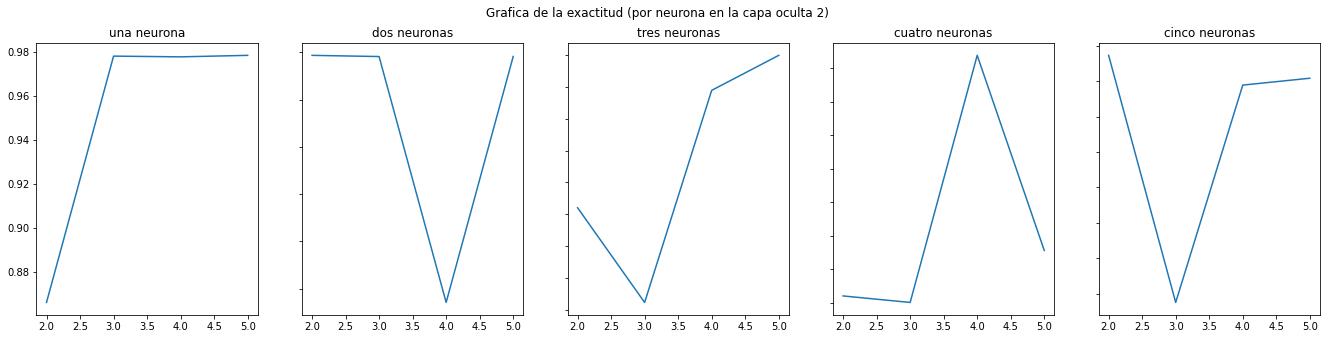

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(23,5))
xs = [2,3,4,5]
fig.suptitle('Grafica de la exactitud (por neurona en la capa oculta 2)')
ax1.plot(xs, accuracy[0])
ax2.plot(xs, accuracy[1])
ax3.plot(xs, accuracy[2])
ax4.plot(xs, accuracy[3])
ax5.plot(xs, accuracy[4])
ax1.title.set_text('una neurona')
ax2.title.set_text('dos neuronas')
ax3.title.set_text('tres neuronas')
ax4.title.set_text('cuatro neuronas')
ax5.title.set_text('cinco neuronas')
for ax in fig.get_axes():
    ax.label_outer()

Para el caso evaluado, interesa maximizar la exactitud del modelo. Gracias a la robustez asegurada por el crossvalidation, se escoje el modelo de 2 capas ocultas con 2 neuronas en ambas capas.

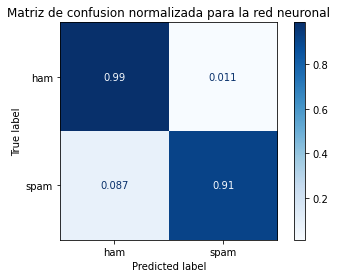

In [16]:
model = MLPClassifier(hidden_layer_sizes=(2, 2 ),
     activation = 'logistic',
     learning_rate = 'adaptive',
     momentum = 0.9,
     learning_rate_init = 0.5,
     random_state = 45,
     max_iter = 10000
     )
model.fit(X_train, y_train_true)
cm = plot_confusion_matrix(model, X_test, y_test_true,
     display_labels=['ham', 'spam'],
     cmap=plt.cm.Blues,
     normalize='true')

cm.ax_.set_title("Matriz de confusion normalizada para la red neuronal")
plt.show()

Este modelo a diferencia del anterior, encuentra más $spam$ con certeza y se equivoca menos en decir que un mensaje $spam$ es considerado como $ham$. Pero arriesga algunos mensajes de tipo $ham$ que no van a llegar por ser considerados $spam$, más que el modelo anterior.

Para el caso objetivo, de que la persona reciba todos sus mensajes $ham$ y trate de reducir los mensajes de $spam$, el mejor modelo es el de la regresión logística. Ya que asegura que mas cantidad de mensajes $ham$ lleguen correctamente con una poca probabilidad de ser considerados $spam$.